# How You Take Photos

This is a python script that visualizes the settings that you have on your camera across a set of photos you take


/Users/sammyrobens-paradise/Desktop/lights


## Include All the Dependencies

First you will need:

- [Python 3](https://www.python.org/downloads/)
- [Homebrew](https://brew.sh)
- [pip](https://pip.pypa.io/en/stable/installation/) (You can also use Conda but)
- [Juypter Notebook](https://jupyter.org/install)

lets include all the depdencies. Before you begin, make sure you have installed the depencies.
You can do this by running `Make install` which will install the dependencies in `requirements.text`. You can also manually install the dependencies listed below.


## Install Dependencies


In [1]:
# install dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ExifTags
from PIL.ExifTags import TAGS
import glob
import os

Input the file path to the folder containing the images you want to visualize


In [2]:
# path_to_image_dir = input("Enter the complete path to the image folder")
path_to_image_dir = "/Users/sammyrobens-paradise/Desktop/lights"
print("Loading images from " + path_to_image_dir + "...")

directory = os.fsencode(path_to_image_dir)
image_paths = glob.glob(path_to_image_dir + "/*")
num_images = len(image_paths)
print(str(num_images) + " images found in " + path_to_image_dir)

Loading images from /Users/sammyrobens-paradise/Desktop/lights...
177 images found in /Users/sammyrobens-paradise/Desktop/lights


In [3]:
# Define all our classes, types and helper functions
class Exif:
    ResolutionUnit: int
    ExifOffset: int
    Make: str
    Model: str
    Software: str
    DateTime: str
    XResolution: float
    YResolution: float
    ExitVersion: bytes
    ShutterSpeedValue: float
    ApertureValue: float
    DateTimeOriginal: str
    DateTimeDigitized: str
    ExposureBiasValue: float
    MaxApertureValue: float
    MeteringMode: int
    ColorSpace: int
    Flash: int
    FocalLength: float
    ExposureMode: int
    WhiteBalance: int
    SceneCaptureType: int
    FocalPlaneXResolution: float
    FocalPlaneYResolution: float
    OffsetTime: str
    SubsecTimeOriginal: str
    SubsecTimeDigitized: str
    FocalPlaneResolutionUnit: int
    ExposureTime: float
    FNumber: float
    ExposureProgram: int
    CustomRendered: int
    ISOSpeedRatings: int
    SensitivityType: int
    RecommendedExposureIndex: int
    LensSpecification: list[float, float, float, float]
    LensModel: str
    LensSerialNumber: str


def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def shutter_speed_to_seconds(shutterSpeed):
    return np.array(2 ** (-1 * shutterSpeed))


def aperture_to_stops(aperture):
    return np.array(np.round((np.power(2, aperture) ** 0.5), 1))


class ImageMetadata:
    def __init__(self, filepath: str):
        source = Image.open(filepath)
        self.source = source
        self.exif: Exif = {
            ExifTags.TAGS[k]: v
            for k, v in source._getexif().items()
            if k in ExifTags.TAGS
        }

    def _get_focal_plane_x_resolution(self):
        return self.exif["FocalPlaneXResolution"]

    def _get_focal_plane_y_resolution(self):
        return self.exif["FocalPlaneYResolution"]

    def _get_shutter_speed_value(self):
        return self.exif["ShutterSpeedValue"]

    def _get_aperture_speed_value(self):
        return self.exif["ApertureValue"]

    def _get_f_number(self):
        return self.exif["FNumber"]

    def _get_ISO_speed_rating(self):
        return self.exif["ISOSpeedRatings"]

    def _get_exposure_time(self):
        return self.exif["ExposureTime"]

## Generate a `data` list
The list contains all of our images and their standard `exif` tagged metadata stored as an `ImageMetadata` object

In [4]:
data:list[ImageMetadata] = []
for path in image_paths:
    curImage = ImageMetadata(path)
    data.append(curImage)

## Now lets get into plotting some data...

### Shutter Speed 

lets plot the shutter speed of your photos

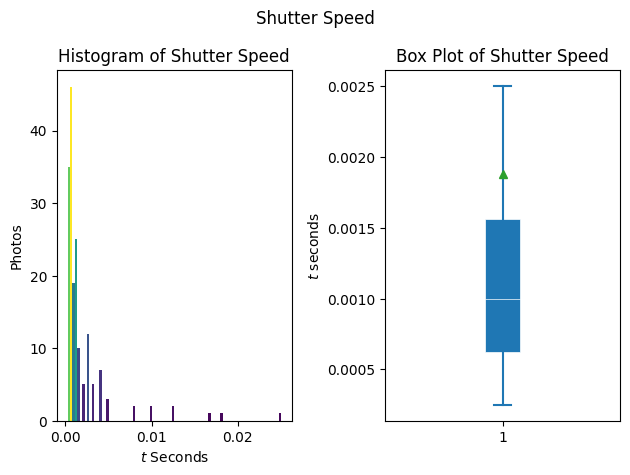

In [5]:
shutterSpeed = []
for item in data:
    shutterSpeed.append(item._get_shutter_speed_value())
    # print(shutterSpeed[len(shutterSpeed) - 1])

shutterSpeed = np.array(shutterSpeed, dtype=float)
Tv = shutter_speed_to_seconds(shutterSpeed)
Tv = reject_outliers(Tv)
bins = int(np.rint(len(Tv) / 2))
fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.suptitle("Shutter Speed")
N, bins, patches = axs[0].hist(Tv, bins=bins)
fracs = N / N.max()
norm = mcolors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
axs[0].set_title("Histogram of Shutter Speed")
axs[0].set_ylabel("Photos")
axs[0].set_xlabel("$t$ Seconds")
axs[1].boxplot(
    Tv,
    patch_artist=True,
    showmeans=True,
    showfliers=False,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
)
axs[1].set_title("Box Plot of Shutter Speed")
axs[1].set_ylabel("$t$ seconds")
axs[1].set_xlabel(" ")
plt.show()

### What about shutter speed relative to Aperture?

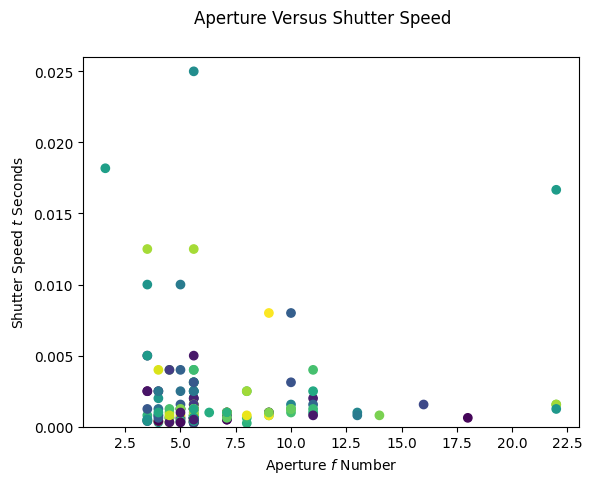

In [6]:
points = np.array(
    [
        [item._get_shutter_speed_value(), item._get_aperture_speed_value()]
        for item in data
    ],
    dtype=float,
)

points[:, 0] = shutter_speed_to_seconds(points[:, 0])
points[:, 1] = aperture_to_stops(points[:, 1])
Tv = points[:, 0]
Av = points[:, 1]

assert len(Tv) == len(Av)
plt.figure()
plt.suptitle("Aperture Versus Shutter Speed")
plt.scatter(Av, Tv, c=np.random.rand(len(points)))
plt.ylim(0, 0.026)
plt.xlabel("Aperture $f$ Number")
plt.ylabel("Shutter Speed $t$ Seconds")

plt.show()

### Whats the $f$ Number for your photos?

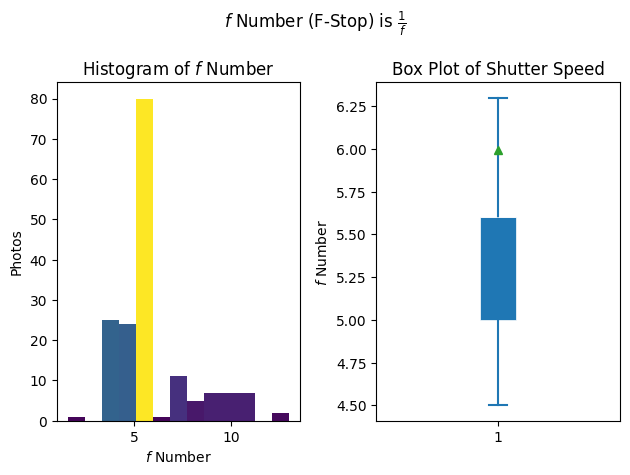

In [7]:
Fn = np.array([item._get_f_number() for item in data], dtype=float)
Fn = reject_outliers(Fn)
bins = len(np.unique(Fn))
fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.suptitle("$f$ Number (F-Stop) is $\\frac{1}{f}$")
N, bins, patches = axs[0].hist(Fn, bins=bins)
fracs = N / N.max()
norm = mcolors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
axs[0].set_title("Histogram of $f$ Number")
axs[0].set_ylabel("Photos")
axs[0].set_xlabel("$f$ Number")
axs[1].boxplot(
    Fn,
    patch_artist=True,
    showmeans=True,
    showfliers=False,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
)
axs[1].set_title("Box Plot of Shutter Speed")
axs[1].set_ylabel("$f$ Number")
axs[1].set_xlabel(" ")
plt.show()

### What about ISO?

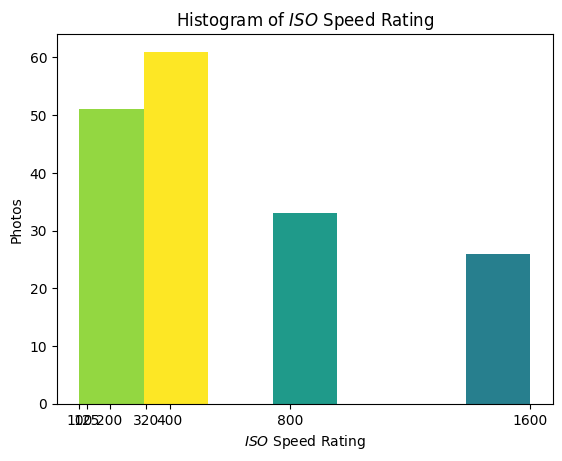

In [8]:
ISO = np.array([item._get_ISO_speed_rating() for item in data], dtype=float)
ISO = reject_outliers(ISO)
bins = len(np.unique(ISO))
plt.figure()
N, bins, patches = plt.hist(ISO, bins=bins)
fracs = N / N.max()
norm = mcolors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.title("Histogram of $ISO$ Speed Rating")
plt.ylabel("Photos")
plt.xlabel("$ISO$ Speed Rating")
plt.xticks(np.unique(ISO))
plt.show()

### What about ISO versus shutter speed?

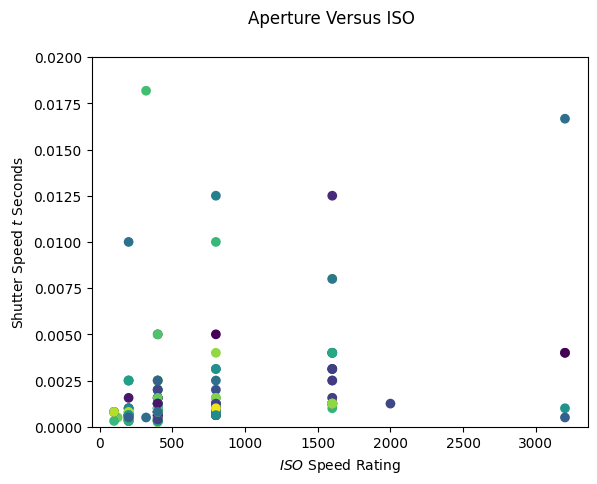

In [9]:
points = np.array(
    [[item._get_shutter_speed_value(), item._get_ISO_speed_rating()] for item in data],
    dtype=float,
)
points[:, 0] = shutter_speed_to_seconds(points[:, 0])
Tv = points[:, 0]
ISO = points[:, 1]
assert len(Tv) == len(ISO)
plt.figure()
plt.suptitle("Aperture Versus ISO")
plt.scatter(ISO, Tv, c=np.random.rand(len(points)))
plt.ylim(0, 0.02)
plt.xlabel("$ISO$ Speed Rating")
plt.ylabel("Shutter Speed $t$ Seconds")
plt.show()

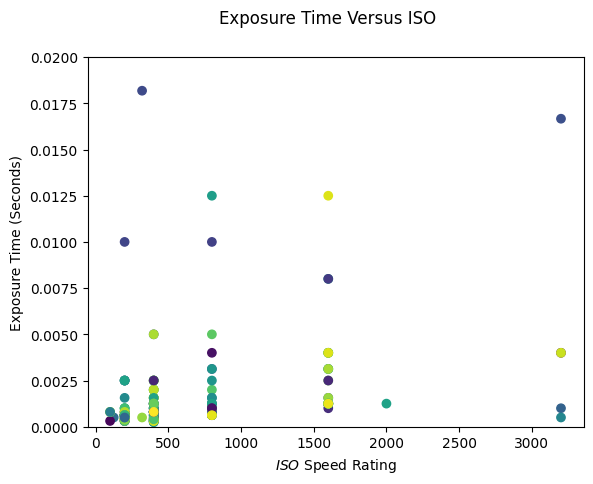

In [10]:
points = np.array(
    [[item._get_ISO_speed_rating(), item._get_exposure_time()] for item in data],
    dtype=float,
)
ISO = points[:, 0]
Et = points[:, 1]
assert len(Et) == len(ISO)
plt.figure()
plt.suptitle("Exposure Time Versus ISO")
plt.scatter(ISO, Et, c=np.random.rand(len(points)))
plt.ylim(0, 0.02)
plt.xlabel("$ISO$ Speed Rating")
plt.ylabel("Exposure Time (Seconds)")
plt.show()